In [10]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.7.1
Torchvision Version:  0.8.2


In [11]:
data_dir = "C:/Users/carlab/Desktop/CV_Assignment_3/Mission_CV/DATASET/"
model_name = "googlenet"

num_classes = 2

batch_size = 128

num_epochs = 25
feature_extract = True

In [12]:
Tr_Loss = []
Tr_Accuracy = []
Val_Loss = []
Val_Accuracy = []

def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()

    for epoch in range(num_epochs):
        scheduler.step()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['TRAIN']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'TRAIN'):
                    
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        _, preds = torch.max(outputs, 1)

                        if phase == 'TRAIN':
                            loss.backward()
                            optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'TRAIN':
                Tr_Loss.append(epoch_loss)
                Tr_Accuracy.append(epoch_acc)
                
            print('{} Loss: {:.4f} Acc: {:.4f} Lr: {}'.format(phase, epoch_loss, epoch_acc, optimizer.param_groups[0]['lr']))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

In [13]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [14]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
        
    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 150
        
    elif model_name == "googlenet":
        """ GoogleNet
        """
        model_ft = torch.hub.load('pytorch/vision:v0.6.0', 'googlenet', pretrained=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

print(model_ft)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

Using cache found in C:\Users\carlab/.cache\torch\hub\pytorch_vision_v0.6.0


In [15]:
data_transforms = {
    'TRAIN': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['TRAIN']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['TRAIN']}

image_datasets

Initializing Datasets and Dataloaders...


{'TRAIN': Dataset ImageFolder
     Number of datapoints: 22564
     Root location: C:/Users/carlab/Desktop/CV_Assignment_3/Mission_CV/DATASET/TRAIN
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [17]:
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.7)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)

Params to learn:
	 fc.weight
	 fc.bias


In [18]:
criterion = nn.CrossEntropyLoss()

model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/24
----------
TRAIN Loss: 0.4646 Acc: 0.8178 Lr: 0.001

Epoch 1/24
----------
TRAIN Loss: 0.3176 Acc: 0.8912 Lr: 0.001

Epoch 2/24
----------
TRAIN Loss: 0.2833 Acc: 0.8972 Lr: 0.001

Epoch 3/24
----------
TRAIN Loss: 0.2620 Acc: 0.9058 Lr: 0.001

Epoch 4/24
----------
TRAIN Loss: 0.2487 Acc: 0.9081 Lr: 0.001

Epoch 5/24
----------
TRAIN Loss: 0.2429 Acc: 0.9086 Lr: 0.001

Epoch 6/24
----------
TRAIN Loss: 0.2342 Acc: 0.9131 Lr: 0.001

Epoch 7/24
----------
TRAIN Loss: 0.2318 Acc: 0.9121 Lr: 0.0001

Epoch 8/24
----------
TRAIN Loss: 0.2317 Acc: 0.9126 Lr: 0.0001

Epoch 9/24
----------
TRAIN Loss: 0.2308 Acc: 0.9161 Lr: 0.0001

Epoch 10/24
----------
TRAIN Loss: 0.2320 Acc: 0.9120 Lr: 0.0001

Epoch 11/24
----------
TRAIN Loss: 0.2294 Acc: 0.9143 Lr: 0.0001

Epoch 12/24
----------
TRAIN Loss: 0.2310 Acc: 0.9119 Lr: 0.0001

Epoch 13/24
----------
TRAIN Loss: 0.2312 Acc: 0.9137 Lr: 0.0001

Epoch 14/24
----------
TRAIN Loss: 0.2271 Acc: 0.9125 Lr: 0.0001

Epoch 15/24
----------
TRAI

TypeError: cannot unpack non-iterable NoneType object

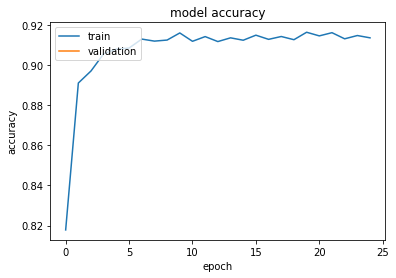

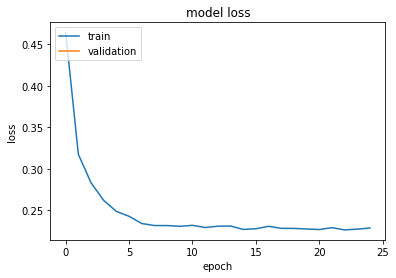

In [19]:
#Accuracy
plt.plot(Tr_Accuracy)
plt.plot(Val_Accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(Tr_Loss)
plt.plot(Val_Loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [20]:
Path = "C:/Users/carlab/Desktop/CV_Assignment_3/Mission_CV/GoogleNet.pth"
torch.save(model_ft.state_dict(), Path)

In [21]:
model = model_ft.load_state_dict(torch.load("C:/Users/carlab/Desktop/CV_Assignment_3/Mission_CV/GoogleNet.pth"))
model = model_ft.eval().to(device)

In [22]:
transform = transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [23]:
def get_predictions(model, Loader):
    A_Preds = torch.tensor([]).to(device = device)
    
    for batch in Loader:
        images, labels = batch

        images = images.to(device = device)
        labels = labels.to(device = device)
     
        pred = model(images)
        A_Preds = torch.cat((A_Preds, pred), dim = 0)
        
        return A_Preds

In [24]:
Test_Dataset = datasets.ImageFolder('C:/Users/carlab/Desktop/CV_Assignment_3/Mission_CV/DATASET/TEST/', transform)

In [25]:
Pred_Loader = torch.utils.data.DataLoader(Test_Dataset, batch_size = 10, shuffle=True)

In [26]:
def get_num_correct (preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [27]:
from sklearn.metrics import confusion_matrix

predlist=torch.zeros(0,dtype=torch.long).to(device)
lbllist=torch.zeros(0,dtype=torch.long).to(device)

with torch.no_grad():
    for i, (inputs, classes) in enumerate(Pred_Loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs).to(device)
        _, preds = torch.max(outputs, 1)

        predlist=torch.cat([predlist,preds.view(-1)])
        lbllist=torch.cat([lbllist,classes.view(-1)])

conf_mat = confusion_matrix(lbllist.cpu().data.numpy(), predlist.cpu().data.numpy())

class_accuracy = 100 * conf_mat.diagonal() / conf_mat.sum(1)

print(conf_mat)

[[1351   50]
 [ 194  918]]


In [48]:
from PIL import Image

filename = ("C:/Users/carlab/Desktop/CV_Assignment_3/Mission_CV/DATASET/TEST/R/R_10003.jpg")
input_image = Image.open(filename)

In [49]:
preprocess = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

input_tensor = preprocess(input_image).to(device)
input_batch = input_tensor.unsqueeze(0)
input_batch.shape

torch.Size([1, 3, 224, 224])

In [50]:
classes = 'O','R'

tensor([0.2129, 0.7871], device='cuda:0')
tensor(1, device='cuda:0')
R


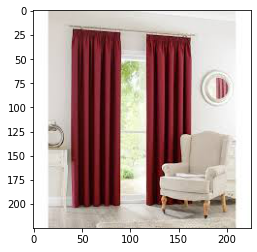

In [51]:
with torch.no_grad():
    output = model(input_batch)

per = torch.nn.functional.softmax(output[0], dim=0)
index = torch.argmax(per, dim = 0)

plt.imshow(input_image)
print(per)
print(index)
print(classes[index])